# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
output_config_dir = os.path.join(ROOT_DIR, 'config')
output_result_dir = os.path.join(ROOT_DIR, 'results')
for directory in [output_result_dir, MODEL_DIR, output_config_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)



# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [2]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
from mrcnn import m_rcnn
from m_rcnn import *
ROOT_DIR="/Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master"

# Extract Images
images_path = "fins_dataset.zip"
annotations_path = "annotations.json"

#extract_images(os.path.join(ROOT_DIR,images_path), "/Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master/content/dataset")




VERS 0.4 - updated 04/08/2022
VERS 0.4 - updated 04/08/2022


In [4]:
dataset_train = load_image_dataset(os.path.join(ROOT_DIR, annotations_path), "/content/dataset", "train")
dataset_val = load_image_dataset(os.path.join(ROOT_DIR, annotations_path), "/content/dataset", "val")
class_number = dataset_train.count_classes()

/content/dataset
Annotation json path:  /Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master\annotations.json
/content/dataset
Annotation json path:  /Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master\annotations.json


In [5]:
print('Train: %d' % len(dataset_train.image_ids))
print('Validation: %d' % len(dataset_val.image_ids))
print("Classes: {}".format(class_number))


Train: 27
Validation: 3
Classes: 3


## Configurations

In [6]:
class FinsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Fins"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 448
    IMAGE_MAX_DIM = 448
    
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (28, 28)  # (height, width) of the mini-mask
    # Use smaller anchors because our image and objects are small
    
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 1
    
    
    
    
    
config = FinsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  448
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0025
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

## Notebook Preferences

In [7]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [8]:
# Training dataset
#dataset_train = ShapesDataset()
#dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
print(np.shape(dataset_train))
dataset_train.prepare()

# Validation dataset
#dataset_val = ShapesDataset()
#dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

()


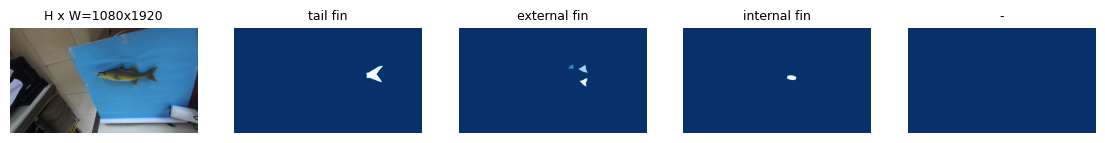

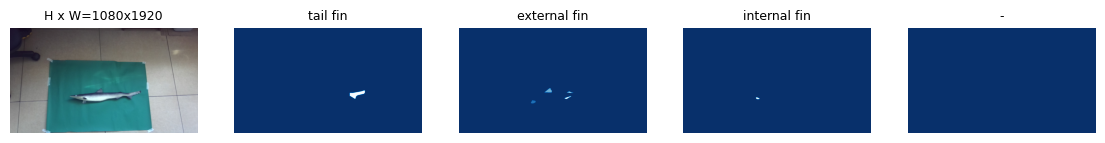

In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 2)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [11]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    print(COCO_MODEL_PATH)
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

C:\Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master\samples\shapes\mask_rcnn_coco.h5


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model = load_training_model(config)
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
           layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=31, 
            layers="all")

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(FinsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)
print(MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "mask_rcnn_shapes_0031.h5")
#model_path = model.find_last()[1]
print(ROOT_DIR)
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights("C:/Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master\logs\mask_rcnn_fins_0031.h5", by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))


In [ ]:

results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'],figsize=(10, 10))#, ax=get_ax())


In [ ]:
a= results[0]
plt.imshow(a['masks'][:,:,0],cmap="gray")

In [ ]:
from PIL import Image
dim = (100, 100)
A = r["masks"][:,:,0]
im = Image.fromarray(A)
mask = im.resize((1920, 1024))
mask.save("C:/Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master\Mask.jpeg")
fig = plt.figure(figsize=(10, 10))
plt.imshow(mask,cmap="gray")

In [ ]:

im2 = Image.fromarray(original_image)
C = im2.resize((1920, 1024))
C.save("C:/Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master\Original.jpeg")

# now, let's make a circular mask with a radius of 100 pixels and
# apply the mask again
img = cv2.imread("C:/Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master\Original.jpeg")
mask = cv2.imread("C:/Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master\Mask.jpeg",0)
masked = cv2.bitwise_and(img, img, mask=mask)
# show the output images
fig = plt.figure(figsize=(10, 10))
plt.imshow(masked)





In [ ]:
NotMask = cv2.bitwise_not(mask)
masked2 =cv2.bitwise_and(img, img, mask=NotMask)

fig = plt.figure(figsize=(20, 9))
ax = plt.subplot(2, 2, 1);
ax.set_title('Original');
plt.imshow(img);
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2, 2, 2);
ax.set_title('Mascara');
plt.imshow(mask, cmap="gray");
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2, 2, 3);
ax.set_title('Enmascarado');
plt.imshow(masked);
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2, 2, 4);
ax.set_title('Salida');
plt.imshow(masked2);
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [ ]:
masked_final = img;
for i in range(np.shape(r["masks"][0][0])[0]):
    A =r["masks"][:,:,i]
    im = Image.fromarray(A)
    mask = im.resize((1920, 1024))
    mask.save("C:/Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master\Mask.jpeg")
    mask = cv2.imread("C:/Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master\Mask.jpeg",0)
    NotMask = cv2.bitwise_not(mask)
    masked_final =cv2.bitwise_and(masked_final, masked_final, mask=NotMask)
plt.imshow(masked_final)

## Evaluation

In [12]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

NameError: name 'inference_config' is not defined

# Para collab

C:\Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master\samples\shapes\logs
/Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master
Loading weights from  /Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master\mask_rcnn_shapes_0031.h5
Processing 1 images
image                    shape: (448, 448, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 448, 448, 3)      min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  448.00000  int32
anchors                  shape: (1, 50127, 4)         min:   -0.20248  max:    1.05931  float32


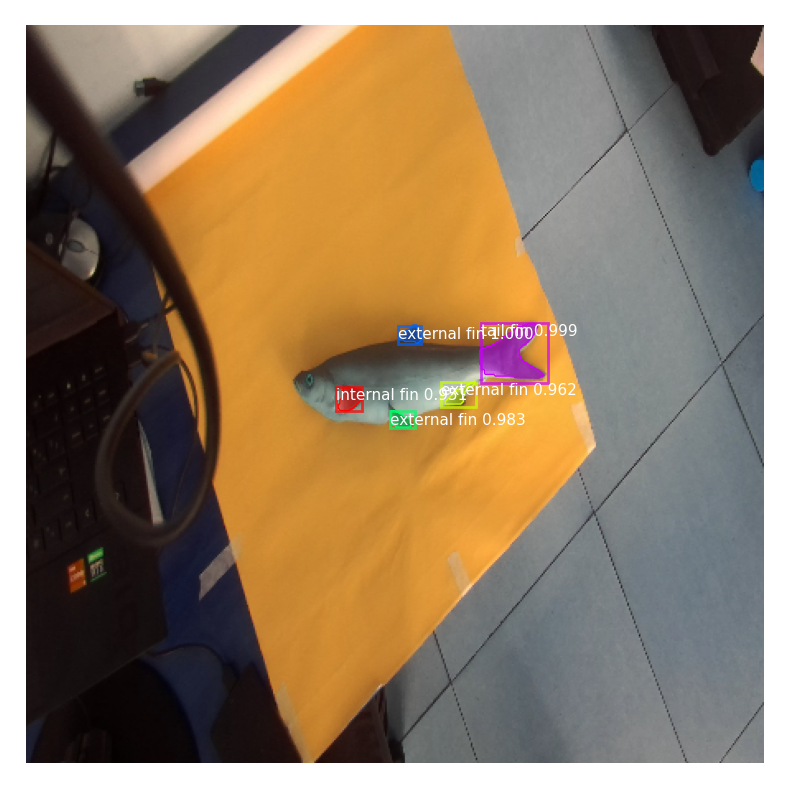

In [23]:
class InferenceConfig(FinsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)
print(MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "mask_rcnn_shapes_0031.h5")
#model_path = model.find_last()[1]
print(ROOT_DIR)
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights("C:/Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master\logs\mask_rcnn_fins_0031.h5", by_name=True)

from PIL import Image

original_image = cv2.imread("C:/Users\jmard\OneDrive\Escritorio\Image3/image.png")

imm = cv2.resize(original_image,(448,448))

results = model.detect([imm], verbose=1)
r = results[0]
visualize.display_instances(imm, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'],figsize=(10, 10))#, ax=get_ax())

True

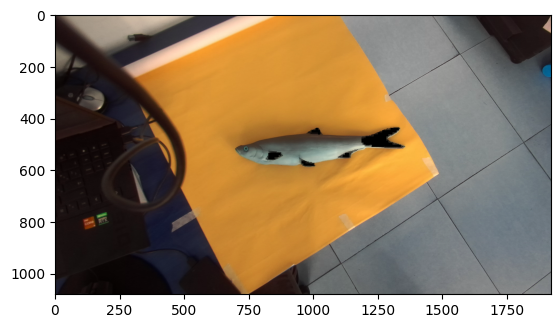

In [24]:
img = cv2.imread("C:/Users\jmard\OneDrive\Escritorio\Image3/image.png")
masked_final = img;
for i in range(np.shape(r["masks"][0][0])[0]):
    A =r["masks"][:,:,i]
    im = Image.fromarray(A)
    mask = im.resize((1920, 1080))
    mask.save("C:/Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master\Mask.jpeg")
    mask = cv2.imread("C:/Users\jmard\Jupyter_Archivos\PDI\Mask-RCNN-TF2-master\Mask.jpeg",0)
    NotMask = cv2.bitwise_not(mask)
    masked_final =cv2.bitwise_and(masked_final, masked_final, mask=NotMask)
plt.imshow(masked_final)

cv2.imwrite("C:/Users\jmard\OneDrive\Escritorio\Image3/custom_mask.png",masked_final)
